In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import simulate_RL, EnvironmentRL
from NEF_WM2 import simulate_WM, EnvironmentWM
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_n and bayes_n with different amounts of noise $\sigma$

In [2]:
def run_bayesn(sid, noise):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    params = [noise, 0]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("bayes_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["bayes_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['noise'] = noise
    return dynamics_data

In [3]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [4]:
sid = 18
noises = [0.2, 0.3, 0.5]
dfs = []
for noise in noises:
    dfs.append(run_bayesn(sid, noise))
bayesn_data = pd.concat(dfs, ignore_index=True)

In [5]:
sid = 18
sigmas = [0.03, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL or NEF_WM with different number of neurons in various populations

In [6]:
def run_NEF(model_type, sid, n_other, n_error, alpha):
    trials = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")['trial'].unique()    
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'n_other', 'n_error', 'response']
    for trial in trials:
        print(f"{model_type}, alpha {alpha}, n_other {n_other}, n_error {n_error}, sid {sid}, trial {trial}")
        seed_net = sid + 1000*trial
        if model_type=="NEF_RL":
            env = EnvironmentRL(dataset="carrabin", sid=sid, trial=trial)
            net, sim = simulate_RL(env=env, alpha=alpha, n_learning=n_other, n_error=n_error, seed_net=seed_net, progress_bar=False)
        if model_type=="NEF_WM":
            env = EnvironmentWM(dataset="carrabin", sid=sid, trial=trial)
            net, sim = simulate_WM(env=env, alpha=alpha, n_memory=n_other, n_error=n_error, seed_net=seed_net, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            response = np.mean(sim.data[net.probe_value][tidx-100: tidx])
            qid = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid & trial==@trial and stage==@stage")['qid'].unique()[0]
            df = pd.DataFrame([[model_type, sid, trial, stage, qid, n_other, n_error, response]], columns=columns)
            dfs.append(df)
    noise_data = pd.concat(dfs, ignore_index=True)
    return noise_data

In [7]:
def add_excursion_alpha(data):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            # n_other = data['n_learning'].unique() if mt=='NEF_WL' else data['n_memory'].unique()
            for n in data['n_other'].unique():
                for e in data['n_error'].unique():
                    subdata = data.query("type==@mt & sid==@sid & n_other==@n & n_error==@e").copy()
                    # if mt=='NEF_RL':
                    #     subdata = data.query("type==@mt & sid==@sid & n_learning==@n & n_error==@e").copy()
                    # if mt=='NEF_WM':
                    #     subdata = data.query("type==@mt & sid==@sid & n_memory==@n & n_error==@e").copy()
                    print(f"{mt} sid {sid}, n_other {n}, n_error {e}")
                    for i, row in subdata.iterrows():
                        trial = row['trial']
                        stage = row['stage']
                        qid = row['qid']
                        response = row['response']
                        avg_response = subdata.query("qid==@qid")['response'].mean()
                        subdata.loc[i, 'excursion'] = response - avg_response
                        if stage>1:
                            stage_old = stage - 1
                            response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                            delta = response_old - response
                            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                            prediction_error = color - response_old
                            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                            subdata.loc[i, 'alpha'] = alpha
                    dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

### run locally

In [ ]:
sid = 18
alpha = 0.2
n_other = [40, 200]
n_error = [40, 200]
dfs = []
for mt in ['NEF_RL', 'NEF_WM']:
    for n in n_other:
        for e in n_other:
            dfs.append(run_NEF(mt, sid, n, e, alpha))
NEF_data = pd.concat(dfs, ignore_index=True)

In [ ]:
NEF_data.to_pickle(f"data/nef_noise_vs_neurons.pkl")

In [ ]:
NEF_data

### run locally with fitted params

In [8]:
sid = 18
n_error = [25, 50, 100]
dfs = []
for mt in ['NEF_WM', 'NEF_RL']:
    params = pd.read_pickle(f"data/{mt}_carrabin_{sid}_params.pkl")
    alpha = params['alpha'].unique()[0]
    n = params['n_memory'].unique()[0] if mt=='NEF_WM' else params['n_learning'].unique()[0]
    for e in n_error:
        dfs.append(run_NEF(mt, sid, n, e, alpha))
NEF_data = pd.concat(dfs, ignore_index=True)

NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 1
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 2
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 3
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 4
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 5
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 6
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 7
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 8
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 9
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 10
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 11
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 12
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 13
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 14
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 15
NEF_WM, alpha 0.23, n_other 200, n_error 25, sid 18, trial 16
NEF_WM, alpha 0.2

### or load

In [39]:
nefrl = pd.read_pickle("data/noise_vs_neurons_NEF_RL_1_feb18.pkl")
nefwm = pd.read_pickle("data/noise_vs_neurons_NEF_WM_1_feb18.pkl")
NEF_data = pd.concat([nefrl, nefwm], ignore_index=True)

# Calculate alpha and excursion and add to the dataframe

In [10]:
NEF_add = add_excursion_alpha(NEF_data)

NEF_WM sid 18, n_other 200, n_error 25
NEF_WM sid 18, n_other 200, n_error 50
NEF_WM sid 18, n_other 200, n_error 100
NEF_WM sid 18, n_other 140, n_error 25
NEF_WM sid 18, n_other 140, n_error 50
NEF_WM sid 18, n_other 140, n_error 100
NEF_RL sid 18, n_other 200, n_error 25
NEF_RL sid 18, n_other 200, n_error 50
NEF_RL sid 18, n_other 200, n_error 100
NEF_RL sid 18, n_other 140, n_error 25
NEF_RL sid 18, n_other 140, n_error 50
NEF_RL sid 18, n_other 140, n_error 100


# Heatmap plot

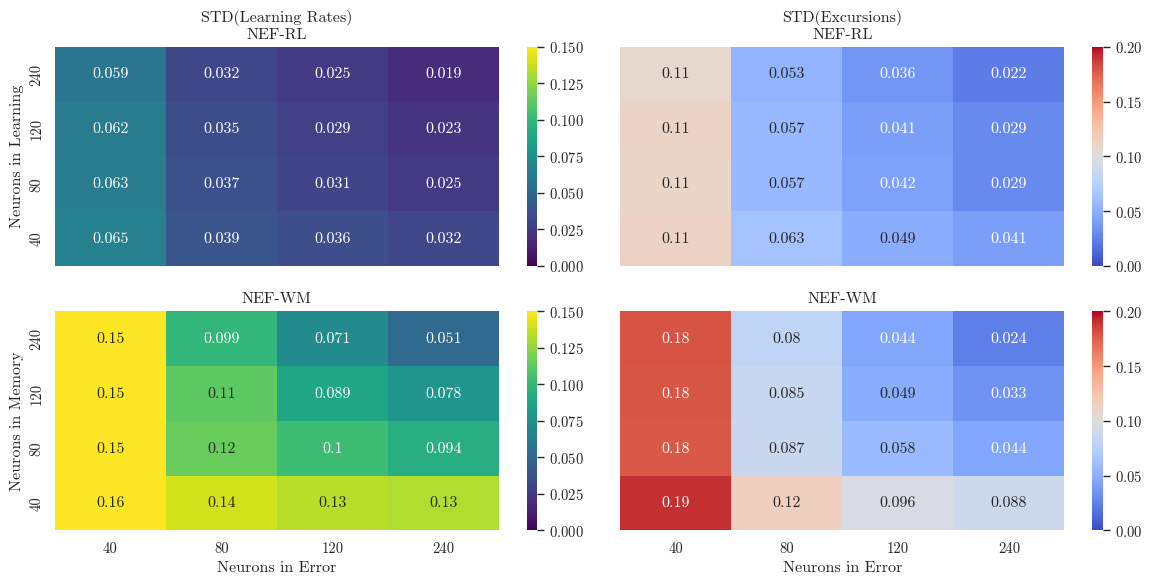

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharex=True, sharey=True)
for mt, model_type in enumerate(['NEF_RL', 'NEF_WM']):
    # alpha_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='alpha', aggfunc='std')
    # excursion_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='excursion', aggfunc='std')
    alpha_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc='std')
    excursion_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc='std')
    sns.heatmap(data=alpha_pivot, annot=True, cmap="viridis", ax=axes[mt][0], vmin=0, vmax=0.15)
    sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", ax=axes[mt][1], vmin=0, vmax=0.2)
    # axes[mt][0].invert_yaxis()
    axes[mt][1].invert_yaxis()
axes[0][0].set(ylabel="Neurons in Learning", xlabel=None, title=f"STD(Learning Rates)\nNEF-RL")
axes[0][1].set(ylabel=None, xlabel=None, title=f"STD(Excursions)\nNEF-RL")
axes[1][0].set(ylabel="Neurons in Memory", xlabel="Neurons in Error", title=f"NEF-WM")
axes[1][1].set(ylabel=None, xlabel="Neurons in Error", title=f"NEF-WM")
plt.tight_layout()
    # fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

### Compare to distribution of std(alpha) and std(excursion) across human SIDs

In [15]:
human = pd.read_pickle("data/carrabin.pkl")
human['n_other'] = 'human'
human['n_error'] = 'human'
human_add = add_excursion_alpha(human)
dfs = []
columns = ['type', 'sid', 'std alpha', 'std excursion']
for sid in human_add['sid'].unique():
    std_alpha = human_add.query("sid==@sid")['alpha'].std()
    std_excursion = human_add.query("sid==@sid")['excursion'].std()
    # print(f"sid {sid}, std alpha {std_alpha:.3}, std excursion {std_excursion:.3}")
    dfs.append(pd.DataFrame([['human', sid, std_alpha, std_excursion]], columns=columns))
human_stds = pd.concat(dfs, ignore_index=True)
print(human_stds)

human sid 1, n_other human, n_error human
human sid 2, n_other human, n_error human
human sid 3, n_other human, n_error human
human sid 4, n_other human, n_error human
human sid 5, n_other human, n_error human
human sid 6, n_other human, n_error human
human sid 7, n_other human, n_error human
human sid 8, n_other human, n_error human
human sid 9, n_other human, n_error human
human sid 10, n_other human, n_error human
human sid 11, n_other human, n_error human
human sid 12, n_other human, n_error human
human sid 13, n_other human, n_error human
human sid 14, n_other human, n_error human
human sid 15, n_other human, n_error human
human sid 16, n_other human, n_error human
human sid 17, n_other human, n_error human
human sid 18, n_other human, n_error human
human sid 19, n_other human, n_error human
human sid 20, n_other human, n_error human
human sid 21, n_other human, n_error human
     type  sid  std alpha  std excursion
0   human    1   0.101987       0.057970
1   human    2   0.14335

In [9]:
# with sns.axes_style("whitegrid"):
#     fig, axes = plt.subplots(nrows=len(human['sid'].unique()), ncols=2, figsize=(8,2*len(human['sid'].unique())), sharex='col')
#     for s, sid in enumerate(human['sid'].unique()):
#         sns.kdeplot(human_add.query("sid==@sid"), x='alpha', clip=[0,1], ax=axes[s][0], color=palette[0], fill=True, common_norm=False)
#         sns.kdeplot(human_add.query("sid==@sid"), x='excursion', clip=[-1,1], ax=axes[s][1], color=palette[0], fill=True, common_norm=False)
#         axes[s][0].set(ylabel=f"SID={sid}", title=f"STD alpha = {human_add.query('sid==@sid')['alpha'].std():.3}")
#         axes[s][1].set(ylabel=None, title=f"STD excursion = {human_add.query('sid==@sid')['excursion'].std():.3}")
#     axes[-1][0].set(xlim=[0,1])
#     axes[-1][1].set(xlim=[-0.5,0.5])
#     plt.tight_layout()
# fig.savefig("plots/alpha_excursions_all_sids.jpg", dpi=600)

# For one SID, compare distribution of alpha, excursions vs above noise parameters

In [12]:
def add_excursion_alpha2(data, noise_label):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            for n in data[noise_label].unique():
                subdata = data.query(f"type==@mt & sid==@sid & {noise_label}==@n").copy()
                print(f"{mt} sid {sid}, {noise_label} {n}")
                for i, row in subdata.iterrows():
                    trial = row['trial']
                    stage = row['stage']
                    qid = row['qid']
                    response = row['response']
                    avg_response = subdata.query("qid==@qid")['response'].mean()
                    subdata.loc[i, 'excursion'] = response - avg_response
                    if stage>1:
                        stage_old = stage - 1
                        response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                        delta = response_old - response
                        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                        prediction_error = color - response_old
                        alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                        subdata.loc[i, 'alpha'] = alpha
                dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [13]:
rln_add = add_excursion_alpha2(RLn_data, 'sigma')
bayesn_add = add_excursion_alpha2(bayesn_data, 'noise')
human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human_add = add_excursion_alpha2(human, 'sigma')
human_add['noise'] = 'human'
human_add['n_learning'] = 'human'
human_add['n_error'] = 'human'
rladd = NEF_add.query("type=='NEF_RL'")
wmadd = NEF_add.query("type=='NEF_WM'")
combined = pd.concat([human_add, bayesn_add, rln_add, rladd, wmadd], ignore_index=True)

RL_n sid 18, sigma 0.03
RL_n sid 18, sigma 0.05
RL_n sid 18, sigma 0.1
bayes_n sid 18, noise 0.2
bayes_n sid 18, noise 0.3
bayes_n sid 18, noise 0.5
human sid 18, sigma human


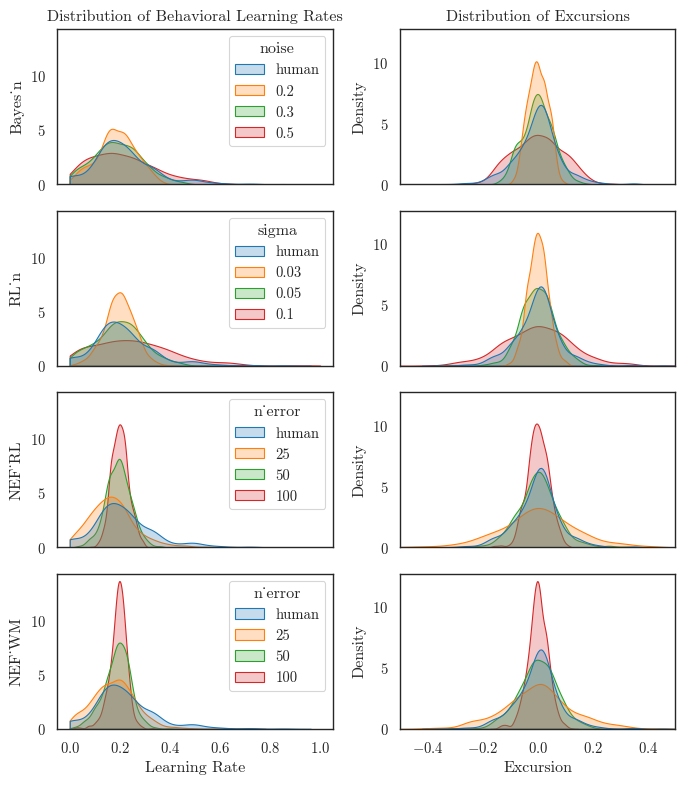

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 8), sharex='col', sharey='col')
bayes_query = ['human', 'bayes_n']
rl_query = ['human', 'RL_n']
nefrl_query = ['human', 'NEF_RL']
nefwm_query = ['human', 'NEF_WM']
sns.kdeplot(combined.query("type==@bayes_query"), x='alpha', hue='noise', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='alpha', hue='sigma', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='alpha', hue='n_error', ax=axes[2][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='alpha', hue='n_error', ax=axes[3][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@bayes_query"), x='excursion', hue='noise', ax=axes[0][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='excursion', hue='n_error', ax=axes[2][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='excursion', hue='n_error', ax=axes[3][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates')
axes[0][1].set(title='Distribution of Excursions')
axes[0][0].set(ylabel='Bayes_n')
axes[1][0].set(ylabel='RL_n')
axes[2][0].set(ylabel='NEF_RL')
axes[3][0].set(ylabel='NEF_WM')
axes[3][0].set(xlabel="Learning Rate")
axes[3][1].set(xlabel='Excursion', xlim=[-0.5, 0.5])
axes[0][1].get_legend().remove()
axes[1][1].get_legend().remove()
axes[2][1].get_legend().remove()
axes[3][1].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/noise_demo_all_model_types.jpg", dpi=600)